<a href="https://colab.research.google.com/github/bcastiblancoo/HZZ-Analysis-13TeV-ATLAS-Open-Data/blob/main/Code/HZZ_Analysis_13TeV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Higgs decay into a pair of Z bosons - Analysis from the 13 TeV ATLAS Open Data release**

This code is mainly based on the "**Python uproot framework**" of the ATLAS Open Data 13 TeV Documentation: 

http://opendata.atlas.cern/release/2020/documentation/index.html

In [1]:
import sys
!pip install uproot3 vector numpy matplotlib

In [2]:
import uproot3 
import pandas as pd 
import vector 
import time 
import math  
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator,AutoMinorLocator 
import infofile

Luminosity, fraction of the data, and file path:

In [3]:
lumi = 10 # fb-1 

fraction = 1.0 # fraction taken from the data
                                                                                                                                  
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/4lep/" # web address for "4lep" sample

Define the samples of the process:

In [4]:
samples = {

    'data': {
        'list' : ['data_A','data_B','data_C','data_D'],
    },
    
    r'$ZZ$' : { # ZZ and diboson background
        'list' : ['llll','ZqqZll','llvv','lllv'], #'lvvv'
        'color' : "#ffe900" # Middle yellow
    },

    r'$Z+jets$' : { # Z + jets
        'list' : ['Zee','Zmumu','Ztautau'],
        'color' : "#6b59d3" # Slate blue   
    },
    
    r'ttbar,single-top' : { # t decay
        'list' : ['ttbar_lep','single_top_tchan','single_antitop_tchan','single_antitop_schan','single_top_wtchan','single_antitop_wtchan'],
        'color' : "#00cdff" # Light blue
    },

    r'Higgs' : { # Higgs boson decay: H -> ZZ -> llll
        'list' : ['ggH125_ZZ4lep','VBFH125_ZZ4lep','WH125_ZZ4lep','ZH125_ZZ4lep'],
        'color' : "#ff0000" # Red
    },

}

Define function to get data from files.

The datasets used in this notebook have already been filtered to include at least 4 leptons per event, so that processing is quicker.

In [5]:
def get_data_from_files():

    data = {} # define empty dictionary to hold dataframes
    nIn_total=0
    nOut_total=0
    for s in samples: # loop over samples
        print('Processing '+s+' samples') # print which sample
        frames = [] # define empty list to hold data
        for val in samples[s]['list']: # loop over each file
            if s == 'data': prefix = "Data/" # Data prefix
            else: # MC prefix
                prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".4lep.root" # file name to open
            temp,nIn,nOut = read_file(fileString,val) # call the function read_file defined below
            nIn_total+=nIn
            nOut_total+=nOut
            frames.append(temp) # append dataframe returned from read_file to list of dataframes
            #print(temp['lep_pt'])
            #print(temp['mllll'])
        data[s] = pd.concat(frames) # dictionary entry is concatenated dataframes
    
    return data, nIn_total, nOut_total # return dictionary of dataframes

Define function to calculate weight of MC event

In [6]:
def calc_weight(xsec_weight, mcWeight, scaleFactor_PILEUP,
                scaleFactor_ELE, scaleFactor_MUON, 
                scaleFactor_LepTRIGGER ):
    return (xsec_weight * mcWeight * scaleFactor_PILEUP * scaleFactor_ELE * scaleFactor_MUON  * scaleFactor_LepTRIGGER)

Define function to get cross-section weight

In [7]:
def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

Define functions to calculate 4-lepton and 2-lepton invariant masses.

Note: Energy and momentum variables are stored in MeV in the samples, so it is necessary to divide those values by 1000 to get them in GeV.

In [8]:
def calc_m_4l(lep_pt, lep_eta, lep_phi, lep_E):
    # first lepton is [0], 2nd lepton is [1] etc
    px_0 = lep_pt[0]*math.cos(lep_phi[0]) # x-component of lepton[0] momentum
    py_0 = lep_pt[0]*math.sin(lep_phi[0]) # y-component of lepton[0] momentum
    pz_0 = lep_pt[0]*math.sinh(lep_eta[0]) # z-component of lepton[0] momentum
    px_1 = lep_pt[1]*math.cos(lep_phi[1]) # x-component of lepton[1] momentum
    py_1 = lep_pt[1]*math.sin(lep_phi[1]) # y-component of lepton[1] momentum
    pz_1 = lep_pt[1]*math.sinh(lep_eta[1]) # z-component of lepton[1] momentum
    px_2 = lep_pt[2]*math.cos(lep_phi[2]) # x-component of lepton[2] momentum
    py_2 = lep_pt[2]*math.sin(lep_phi[2]) # y-component of lepton[2] momentum
    pz_2 = lep_pt[2]*math.sinh(lep_eta[2]) # z-component of lepton[2] momentum
    px_3 = lep_pt[3]*math.cos(lep_phi[3]) # x-component of lepton[3] momentum
    py_3 = lep_pt[3]*math.sin(lep_phi[3]) # y-component of lepton[3] momentum
    pz_3 = lep_pt[3]*math.sinh(lep_eta[3]) # z-component of lepton[3] momentum    
    sumpx = px_0 + px_1 + px_2 + px_3 # x-component of momentum
    sumpy = py_0 + py_1 + py_2 + py_3 # y-component of momentum
    sumpz = pz_0 + pz_1 + pz_2 + pz_3 # z-component of momentum 
    sump = math.sqrt(sumpx**2 + sumpy**2 + sumpz**2) # magnitude of momentum 
    sumE = lep_E[0] + lep_E[1] + lep_E[2] + lep_E[3] # energy of dilepton system
    return math.sqrt(sumE**2 - sump**2)/1000 #/1000 to go from MeV to GeV

In [9]:
def calc_ml1l2(lep_pt, lep_eta, lep_phi, lep_E):
    px_0 = lep_pt[0]*math.cos(lep_phi[0]) 
    py_0 = lep_pt[0]*math.sin(lep_phi[0]) 
    pz_0 = lep_pt[0]*math.sinh(lep_eta[0])
    px_1 = lep_pt[1]*math.cos(lep_phi[1]) 
    py_1 = lep_pt[1]*math.sin(lep_phi[1]) 
    pz_1 = lep_pt[1]*math.sinh(lep_eta[1]) 
    sumpx = px_0 + px_1  
    sumpy = py_0 + py_1 
    sumpz = pz_0 + pz_1  
    sump = math.sqrt(sumpx**2 + sumpy**2 + sumpz**2)  
    sumE = lep_E[0] + lep_E[1] 
    return math.sqrt(sumE**2 - sump**2)/1000 

In [10]:
def calc_ml3l4(lep_pt, lep_eta, lep_phi, lep_E):
    px_3 = lep_pt[2]*math.cos(lep_phi[2]) 
    py_3 = lep_pt[2]*math.sin(lep_phi[2]) 
    pz_3 = lep_pt[2]*math.sinh(lep_eta[2])
    px_4 = lep_pt[3]*math.cos(lep_phi[3]) 
    py_4 = lep_pt[3]*math.sin(lep_phi[3]) 
    pz_4 = lep_pt[3]*math.sinh(lep_eta[3]) 
    sumpx = px_3 + px_4  
    sumpy = py_3 + py_4  
    sumpz = pz_3 + pz_4 
    sump = math.sqrt(sumpx**2 + sumpy**2 + sumpz**2) 
    sumE = lep_E[2] + lep_E[3] 
    return math.sqrt(sumE**2 - sump**2)/1000 

Define functions to get the data from the samples and fill the histograms:

In [11]:
def leadlepton_pt(lep_pt):
  return lep_pt[0]/1000.

In [12]:
def lepton_pt(lep_pt,lep_n):
  for i in range(lep_n):
    return lep_pt[i]/1000.

In [13]:
def lepton_energy(lep_E,lep_n):
  for i in range(lep_n):
    return lep_E[i]/1000.

In [14]:
def lepton_eta(lep_eta,lep_n):
  for i in range (lep_n):
    return lep_eta[i]

In [15]:
def lepton_phi(lep_phi,lep_n):
  for i in range(lep_n):
    return lep_phi[i]

In [16]:
def number_leptons(lep_n):
  return lep_n

In [17]:
def number_jets(jet_n):
  return jet_n

In [18]:
def lepton_charge(lep_charge,lep_n):
  for i in range(lep_n):
    return lep_charge[i]

In [19]:
def lepton_flavour(lep_type,lep_n):
  for i in range (lep_n):
    return lep_type[i]

**Event selection criteria**

The following lines correspond to the definition of functions for the event selection criteria for the H--->ZZ analysis:

In [20]:
def trigger(trigE, trigM):
    if((trigE != True) and (trigM != True)): 
      return True
    return False

def goodlep_cut(lep_n, lep_pt, lep_eta, lep_ptcone30, lep_etcone20, lep_type):
    goodlep_n=0

    for i in range (lep_n):
        #if(lep_isTightID[i]==False): #optional cut-reduce number of events
        #  continue
        #Loose lepton
        if(lep_pt[i]<=5000. or (lep_ptcone30[i]/lep_pt[i]>=0.3) or (lep_etcone20[i]/lep_pt[i]>=0.3)): 
          continue
        # electron and muon detection regions
        #for electrons
        if(lep_type[i]==11 and abs(lep_eta[i])<2.47 and (abs(lep_eta[i])<1.37 or abs(lep_eta[i])>1.52)): 
            goodlep_n+=1
        #for muons
        if(lep_type[i]==13 and abs(lep_eta[i])<2.5):
            goodlep_n+=1
                   
    if(goodlep_n==4): 
      return False
    return True    

def cut_lep_pt(lep_pt):
    return lep_pt[0]<25000. or lep_pt[1]<15000. or lep_pt[2]<10000. or lep_pt[3]<7000.

def cut_lep_charge(lep_charge):     
    if(lep_charge[0] + lep_charge[1] + lep_charge[2] + lep_charge[3] != 0): 
      return True
    return False
    
def cut_lep_type(lep_type):
    sum_lep_type = lep_type[0] + lep_type[1] + lep_type[2] + lep_type[3]
    if((sum_lep_type != 44) and (sum_lep_type != 48) and (sum_lep_type != 52)): 
      return True
    return False

#def cut_number_jets(jet_n):        # Optional cut in jets
#  if jet_n != 0:
#    return True
#  return False    

**Run the analysis**

The following line is the function which run the analysis: Events are selected from the data samples based on the selection criteria defined above.

In [21]:
def read_file(path,sample):
    
    print("\tProcessing: "+sample) # print which sample is being processed
    data_all = pd.DataFrame() # define empty pandas DataFrame to hold all data for this sample
    tree = uproot3.open(path)["mini"] # open the tree called mini
    numevents = uproot3.numentries(path, "mini") # number of events
    if 'data' not in sample: xsec_weight = get_xsec_weight(sample) # get cross-section weight
    nIn_total=0
    nOut_total=0
    for data in tree.iterate(['lep_charge','lep_type','lep_pt', #Call the variables that will be used
                              'lep_ptcone30','lep_etcone20',
                              'lep_eta','lep_phi','lep_E','lep_n',
                              'mcWeight','scaleFactor_PILEUP',
                              'scaleFactor_ELE','scaleFactor_MUON',
                              'scaleFactor_LepTRIGGER','trigE','trigM','jet_n'],
                             outputtype=pd.DataFrame,
                             entrystop=numevents*fraction): 

        nIn = len(data.index) # number of events in this step
        nIn_total+=nIn
        nOut = 0
        if 'data' not in sample: # only do this for Monte Carlo simulation files
            # multiply all Monte Carlo weights and scale factors together to give total weight
        
            data['totalWeight'] = np.vectorize(calc_weight)(xsec_weight,
                                                            data.mcWeight,
                                                            data.scaleFactor_PILEUP,
                                                            data.scaleFactor_ELE,
                                                            data.scaleFactor_MUON,
                                                            data.scaleFactor_LepTRIGGER)
          
        #Apply the cuts to select the events

        #cut on trigger
        fail = data[np.vectorize(trigger)(data.trigE, data.trigM) ].index # get events that fail this selection
        data.drop(fail,inplace=True) # drop the events with fewer than
        if len(data.index)==0: 
          continue # move onto next batch if no events left 

        #cut on goodlepton
        fail = data[np.vectorize(goodlep_cut)(data.lep_n, data.lep_pt, data.lep_eta, data.lep_ptcone30, 
                                               data.lep_etcone20, data.lep_type) ].index 
        data.drop(fail,inplace=True) 
        if len(data.index)==0: 
          continue 

        #Cut on lepton pTs:
        fail = data[np.vectorize(cut_lep_pt)(data.lep_pt)].index
        data.drop(fail,inplace=True)
        if len(data.index)==0:
          continue

        #cut on charge and lepton type:       
        
        fail = data[ np.vectorize(cut_lep_charge)(data.lep_charge) ].index 
        data.drop(fail,inplace=True) 
        if len(data.index)==0:
          continue 
            
        fail = data[ np.vectorize(cut_lep_type)(data.lep_type) ].index 
        data.drop(fail,inplace=True) 
        if len(data.index)==0:
          continue 

        #cut on number of jets:

        #fail = data[ np.vectorize(cut_number_jets)(data.jet_n) ].index
        #data.drop(fail,inplace=True)  
        #if len(data.index)==0:
        #  continue 

        #Fill the histograms for the Distribution plots:

        data['lepton_pt'] = np.vectorize(lepton_pt)(data.lep_pt,data.lep_n)
        data['lepton_e'] = np.vectorize(lepton_energy)(data.lep_E,data.lep_n)
        data['lepton_phi'] = np.vectorize(lepton_phi)(data.lep_phi,data.lep_n)
        data['lepton_eta'] = np.vectorize(lepton_eta)(data.lep_eta,data.lep_n)
        data['leadlepton_pt'] = np.vectorize(leadlepton_pt)(data.lep_pt)
        data['number_leptons'] = np.vectorize(number_leptons)(data.lep_n)
        data['number_jets'] = np.vectorize(number_jets)(data.jet_n)
        data['lepton_charge'] = np.vectorize(lepton_charge)(data.lep_charge,data.lep_n)
        data['lepton_type'] = np.vectorize(lepton_flavour)(data.lep_type,data.lep_n)

        # calculation of the 4-lepton and 2-lepton invariant masses using the functions defined above:

        data['m_4l'] = np.vectorize(calc_m_4l)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_E)
        data['ml1l2'] = np.vectorize(calc_ml1l2)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_E)
        data['ml3l4'] = np.vectorize(calc_ml3l4)(data.lep_pt,data.lep_eta,data.lep_phi,data.lep_E)
        nOut = len(data.index) # number of events passing cuts in this batch
        nOut_total+=nOut
        data_all = data_all.append(data) # append dataframe from this batch to the dataframe for the whole sample
        print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)) # events before and after
    
    print("\t\t nIn_total: "+str(nIn_total)+",\t nOut_total: \t"+str(nOut_total))

    return data_all, nIn_total, nOut_total # return dataframe containing events passing all cuts

In [22]:
data,nIn_total,nOut_total = get_data_from_files()
print("Number of input events:",nIn_total)
print("Number of output events:",nOut_total)

Processing data samples
	Processing: data_A
		 nIn: 39,	 nOut: 	19
		 nIn_total: 39,	 nOut_total: 	19
	Processing: data_B
		 nIn: 156,	 nOut: 	55
		 nIn_total: 156,	 nOut_total: 	55
	Processing: data_C
		 nIn: 237,	 nOut: 	105
		 nIn_total: 237,	 nOut_total: 	105
	Processing: data_D
		 nIn: 400,	 nOut: 	186
		 nIn_total: 400,	 nOut_total: 	186
Processing $ZZ$ samples
	Processing: llll
		 nIn: 106415,	 nOut: 	87619
		 nIn: 106415,	 nOut: 	87585
		 nIn: 106415,	 nOut: 	87515
		 nIn: 106415,	 nOut: 	87491
		 nIn: 106415,	 nOut: 	87475
		 nIn: 22204,	 nOut: 	18287
		 nIn_total: 554279,	 nOut_total: 	455972
	Processing: ZqqZll
		 nIn: 254,	 nOut: 	26
		 nIn_total: 254,	 nOut_total: 	26
	Processing: llvv
		 nIn: 137,	 nOut: 	17
		 nIn_total: 137,	 nOut_total: 	17
	Processing: lllv
		 nIn: 9340,	 nOut: 	1522
		 nIn_total: 9340,	 nOut_total: 	1522
Processing $Z+jets$ samples
	Processing: Zee
		 nIn: 898,	 nOut: 	110
		 nIn_total: 898,	 nOut_total: 	110
	Processing: Zmumu
		 nIn: 684,	 nOut: 	1

**Plotting**

For each variable it is necessary to define a function which plots it.

4-lepton invariant mass (Higgs mass):

In [23]:
def plot_mH(data):

    xmin = 80 #GeV
    xmax = 176  #GeV
    step_size = 8 #Gev/bin

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data['data']['m_4l'], 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data
    data_mass_errors = step_size/2

    signal_x = data[r'Higgs']['m_4l'] # histogram the signal
    signal_weights = data[r'Higgs'].totalWeight # get the weights of the signal events
    signal_color = samples[r'Higgs']['color'] # get the colour for the signal bar


    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', r'Higgs']: # if not data nor signal
            mc_x.append( data[s]['m_4l'] ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels


    # *************
    # Main plot 
    # *************

    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_x, yerr=data_x_errors,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
 
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

    #Calculate the Data/Pred. ratio, taking the closest value of the data to the MC value

    data_pred=(data_x-data_x_errors)/mc_x_tot
    data_pred_errors=np.sqrt(data_pred) #stat. unc.

    # plot the signal bar
    main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
                   weights=signal_weights, color=signal_color,
                   label=r'Higgs')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err,
                  color='none', hatch="////", width=step_size, label='Stat. unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    #main_axes.set_xlabel(r'$\mathrm{m_{T}(4l)}$ [GeV]',
    #                    fontsize=13, x=1, horizontalalignment='right' ) 
    
    main_axes.set_ylabel('Number of events/bin',
                         y=1, horizontalalignment='right')

    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.5)
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False)

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
  
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.865, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.805, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False ) # no box around the legend

    # *************
    # Data/Bkg plot 
    # *************


    plt.axes([0.125,-0.1,0.775,0.225]) # left, bottom, width, height
    sub_axes = plt.gca() # get the current axes

    sub_axes.yaxis.set_major_locator( MaxNLocator(nbins='auto', 
                                                  symmetric=True) )
    
    sub_axes.set_ylim(bottom=0, top=np.amax(data_pred)*1.5)

    # plot Data/Background
    sub_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_pred, yerr=data_pred_errors,
                      fmt='ko' ) # 'k' means black and 'o' means circles

    sub_axes.axhline(1.0,ls='--',c='b')
    sub_axes.axvline(125.0,ls='--',c='r')                  

    # set the x-axis limits on the sub axes
    sub_axes.set_xlim( left=xmin, right=xmax )

    # separation of x-axis minor ticks
    sub_axes.xaxis.set_minor_locator( AutoMinorLocator() )
    sub_axes.set_xticks([80,90,100,110,120,130,140,150,160,170]) 
    
    # x-axis label
    sub_axes.set_xlabel(r'$\mathrm{m_{4\ell}}$ [GeV]',
                        x=1, horizontalalignment='right', 
                        fontsize=13 )
    
    # set the tick parameters for the sub axes
    sub_axes.tick_params(which='both', # ticks on both x and y axes
                         direction='in', # Put ticks inside and outside the axes
                         top=True, # draw ticks on the top axis
                         right=True ) # draw ticks on right axis

    # separation of y-axis minor ticks
    sub_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    sub_axes.set_yticks([-1.0,0,1.0,2.0])

    # y-axis label on the sub axes
    sub_axes.set_ylabel( 'Data/Pred' )

    # Generic features for both plots
    main_axes.yaxis.set_label_coords( -0.09, 1 ) # x,y coordinates of the y-axis label on the main axes
    sub_axes.yaxis.set_label_coords( -0.09, 0.5 ) # x,y coordinates of the y-axis label on the sub axes

    plt.savefig("m_H.png",bbox_inches='tight')

    return

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


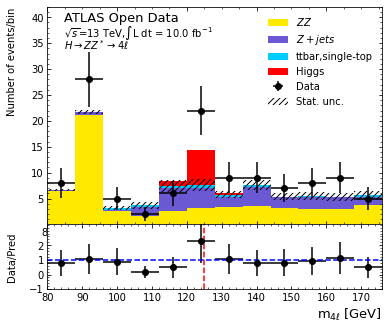

In [24]:
plot_mH(data)

For the transverse momentum of the leptons:

In [25]:
def plot_lep_pt(data):

    xmin = 0 
    xmax = 400  #GeV
    step_size = 40

    bin_edges = np.arange(start=xmin, 
                     stop=xmax+step_size, 
                     step=step_size ) 
    bin_centres = np.arange(start=xmin+step_size/2, 
                            stop=xmax+step_size/2, 
                            step=step_size ) 

    data_x,_ = np.histogram(data['data']['lepton_pt'], 
                            bins=bin_edges ) 
    data_x_errors = np.sqrt( data_x ) 
    data_mass_errors = step_size/2

    mc_x = [] 
    mc_weights = [] 
    mc_colors = [] 
    mc_labels = [] 

    for s in samples: 
        if s not in ['data']: 
            mc_x.append( data[s]['lepton_pt']) 
            mc_weights.append( data[s].totalWeight ) 
            mc_colors.append( samples[s]['color'] )
            mc_labels.append( s ) 


    # *************
    # Main plot 
    # *************

    main_axes = plt.gca() 
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_x, yerr=data_x_errors,
                       fmt='ko', # 'k' means black and 'o' is for circles 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
 
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err,
                  color='none', hatch="////", width=step_size, label='Stat. unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', 
                          direction='in', 
                          top=True, 
                          right=True ) 
    
    # x-axis label
    main_axes.set_xlabel(r'$p_{T}[GeV]$',
                        fontsize=13, x=1, horizontalalignment='right' ) 
    
    main_axes.set_ylabel('Number of events/bin',
                         y=1, horizontalalignment='right')

    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6)
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False)

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, 
             0.93, 
             'ATLAS Open Data', 
             transform=main_axes.transAxes, 
             fontsize=13 ) 
    
  
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) 
    plt.text(0.05, # x
             0.865, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', 
             transform=main_axes.transAxes ) 
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.805, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', 
             transform=main_axes.transAxes ) 

    # draw the legend
    main_axes.legend( frameon=False )

    plt.savefig("lep_pt.png",bbox_inches='tight')

    return

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


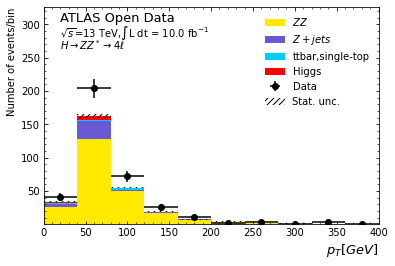

In [26]:
plot_lep_pt(data)

For the leading lepton (lepton with greatest transverse momentum):

In [27]:
def plot_leadpt(data):

    xmin = 0  
    xmax = 400 #GeV  
    step_size = 40

    bin_edges = np.arange(start=xmin, 
                     stop=xmax+step_size, 
                     step=step_size ) 
    bin_centres = np.arange(start=xmin+step_size/2, 
                            stop=xmax+step_size/2, 
                            step=step_size ) 

    data_x,_ = np.histogram(data['data']['leadlepton_pt'], 
                            bins=bin_edges ) 
    data_x_errors = np.sqrt( data_x ) 
    data_mass_errors = step_size/2

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: 
        if s not in ['data']: 
            mc_x.append( data[s]['leadlepton_pt']) 
            mc_weights.append( data[s].totalWeight ) 
            mc_colors.append( samples[s]['color'] ) 
            mc_labels.append( s ) 


    # *************
    # Main plot 
    # *************

    main_axes = plt.gca() 
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_x, yerr=data_x_errors,
                       fmt='ko', 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
 
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err,
                  color='none', hatch="////", width=step_size, label='Stat. unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', 
                          direction='in', 
                          top=True,
                          right=True ) 
    
    # x-axis label
    main_axes.set_xlabel(r'$p_{T}^{leadlep}[GeV]$',
                        fontsize=13, x=1, horizontalalignment='right' ) 
    
    main_axes.set_ylabel('Number of leptons/bin',
                         y=1, horizontalalignment='right')

    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6)
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False)

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, 
             0.93, 
             'ATLAS Open Data', 
             transform=main_axes.transAxes, 
             fontsize=13 ) 
    
  
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) 
    plt.text(0.05, 
             0.865, 
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', 
             transform=main_axes.transAxes ) 
    
    # Add a label for the analysis carried out
    plt.text(0.05, 
             0.805, 
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', 
             transform=main_axes.transAxes )

    # draw the legend
    main_axes.legend( frameon=False ) 

    plt.savefig("leadlep_pt.png",bbox_inches='tight')

    return

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


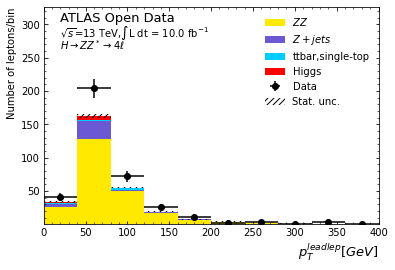

In [28]:
plot_leadpt(data)

For the lepton energy:

In [30]:
def plot_lep_energy(data):

    xmin = 25 
    xmax = 400  #GeV
    step_size = 25

    bin_edges = np.arange(start=xmin,
                     stop=xmax+step_size, 
                     step=step_size ) 
    bin_centres = np.arange(start=xmin+step_size/2, 
                            stop=xmax+step_size/2, 
                            step=step_size ) 

    data_x,_ = np.histogram(data['data']['lepton_e'], 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data
    data_mass_errors = step_size/2

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: 
        if s not in ['data']: 
            mc_x.append( data[s]['lepton_e']) 
            mc_weights.append( data[s].totalWeight ) 
            mc_colors.append( samples[s]['color'] ) 
            mc_labels.append( s ) 


    # *************
    # Main plot 
    # *************

    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_x, yerr=data_x_errors,
                       fmt='ko', 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
 
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, 
                  2*mc_x_err,
                  alpha=0.5, 
                  bottom=mc_x_tot-mc_x_err,
                  color='none', hatch="////", width=step_size, label='Stat. unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', 
                          direction='in', 
                          top=True,
                          right=True ) 
    
    # x-axis label
    main_axes.set_xlabel(r'$E_{leps}[GeV]$',
                        fontsize=13, x=1, horizontalalignment='right' ) 
    
    main_axes.set_ylabel('Number of events/bin',
                         y=1, horizontalalignment='right')

    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6)
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False)

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, 
             0.93, 
             'ATLAS Open Data', 
             transform=main_axes.transAxes, 
             fontsize=13 ) 
    
  
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) 

    plt.text(0.05,  
             0.865, 
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', 
             transform=main_axes.transAxes ) 
    
    # Add a label for the analysis carried out
    plt.text(0.05, 
             0.805, 
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', 
             transform=main_axes.transAxes ) 

    # draw the legend
    main_axes.legend( frameon=False ) 

    plt.savefig("lep_energy.png",bbox_inches='tight')

    return

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


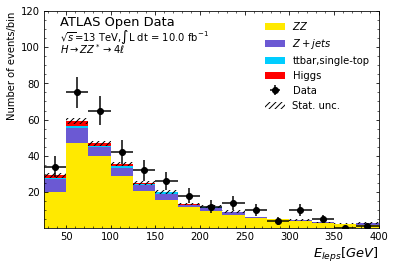

In [31]:
plot_lep_energy(data)

The angle in the xy plane:

In [32]:
def plot_lep_phi(data):

    xmin = -3.5 
    xmax = 3.5 #rad
    step_size = 0.5

    bin_edges = np.arange(start=xmin, 
                     stop=xmax+step_size, 
                     step=step_size ) 
    bin_centres = np.arange(start=xmin+step_size/2,
                            stop=xmax+step_size/2, 
                            step=step_size ) 

    data_x,_ = np.histogram(data['data']['lepton_phi'], 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data
    data_mass_errors = step_size/2

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: 
        if s not in ['data']: 
            mc_x.append( data[s]['lepton_phi']) 
            mc_weights.append( data[s].totalWeight )
            mc_colors.append( samples[s]['color'] ) 
            mc_labels.append( s ) 


    # *************
    # Main plot 
    # *************

    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_x, yerr=data_x_errors,
                       fmt='ko', 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
 
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, 
                  2*mc_x_err, 
                  alpha=0.5, 
                  bottom=mc_x_tot-mc_x_err,
                  color='none', hatch="////", width=step_size, label='Stat. unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', 
                          direction='in', 
                          top=True, 
                          right=True ) 
    
    # x-axis label
    main_axes.set_xlabel(r'$\phi_{leps}$',
                        fontsize=13, x=1, horizontalalignment='right' ) 
    
    main_axes.set_ylabel('Number of events/bin',
                         y=1, horizontalalignment='right')

    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6)
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False)

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, 
             0.93,
             'ATLAS Open Data',
             transform=main_axes.transAxes, 
             fontsize=13 ) 
    
  
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) 
    plt.text(0.05, 
             0.865, 
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', 
             transform=main_axes.transAxes ) 
    
    # Add a label for the analysis carried out
    plt.text(0.05, 
             0.805, 
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', 
             transform=main_axes.transAxes ) 

    # draw the legend
    main_axes.legend( frameon=False )

    plt.savefig("lep_phi.png",bbox_inches='tight')

    return

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


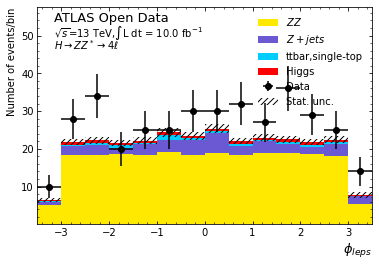

In [33]:
plot_lep_phi(data)

For the pseudorapidity (how far is the lepton from the xy-plane)

In [34]:
def plot_lep_eta(data):

    xmin = -3
    xmax = 3
    step_size = 0.5

    bin_edges = np.arange(start=xmin, 
                     stop=xmax+step_size,
                     step=step_size ) 
    bin_centres = np.arange(start=xmin+step_size/2, 
                            stop=xmax+step_size/2, 
                            step=step_size ) 

    data_x,_ = np.histogram(data['data']['lepton_eta'], 
                            bins=bin_edges ) 
    data_x_errors = np.sqrt( data_x ) 
    data_mass_errors = step_size/2

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: 
        if s not in ['data']: 
            mc_x.append( data[s]['lepton_eta']) 
            mc_weights.append( data[s].totalWeight ) 
            mc_colors.append( samples[s]['color'] ) 
            mc_labels.append( s ) 


    # *************
    # Main plot 
    # *************

    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_x, yerr=data_x_errors,
                       fmt='ko', 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
 
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, 
                  2*mc_x_err, 
                  alpha=0.5, 
                  bottom=mc_x_tot-mc_x_err,
                  color='none', hatch="////", width=step_size, label='Stat. unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', 
                          direction='in', 
                          top=True, 
                          right=True ) 
    
    # x-axis label
    main_axes.set_xlabel(r'$\eta_{leps}$',
                        fontsize=13, x=1, horizontalalignment='right' ) 
    
    main_axes.set_ylabel('Number of events/bin',
                         y=1, horizontalalignment='right')

    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6)
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False)

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05,
             0.93, 
             'ATLAS Open Data', 
             transform=main_axes.transAxes, 
             fontsize=13 ) 
    
  
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, 
             0.865, 
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$',
             transform=main_axes.transAxes ) 
    
    # Add a label for the analysis carried out
    plt.text(0.05, 
             0.805, 
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$',
             transform=main_axes.transAxes ) 

    # draw the legend
    main_axes.legend( frameon=False ) 

    plt.savefig("lep_eta.png",bbox_inches='tight')

    return

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


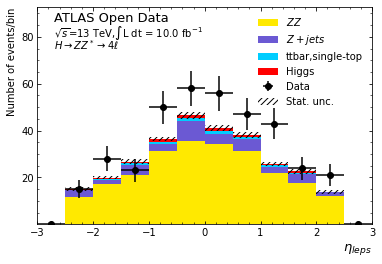

In [35]:
plot_lep_eta(data)

The number of leptons:

In [36]:
def plot_number_leptons(data):

    xmin = 0 
    xmax = 10  
    step_size = 1

    bin_edges = np.arange(start=xmin,
                     stop=xmax+step_size, 
                     step=step_size ) 
    bin_centres = np.arange(start=xmin+step_size/2, 
                            stop=xmax+step_size/2, 
                            step=step_size )

    data_x,_ = np.histogram(data['data']['number_leptons'], 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data
    data_mass_errors = step_size/2

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: 
        if s not in ['data']:
            mc_x.append( data[s]['number_leptons'])
            mc_weights.append( data[s].totalWeight ) 
            mc_colors.append( samples[s]['color'] ) 
            mc_labels.append( s ) 


    # *************
    # Main plot 
    # *************

    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_x, yerr=data_x_errors,
                       fmt='ko', 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
 
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, 
                  2*mc_x_err, 
                  alpha=0.5, 
                  bottom=mc_x_tot-mc_x_err,
                  color='none', hatch="////", width=step_size, label='Stat. unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', 
                          direction='in', 
                          top=True, 
                          right=True ) 
    
    # x-axis label
    main_axes.set_xlabel(r'Number of leptons',
                        fontsize=13, x=1, horizontalalignment='right' ) 
    
    main_axes.set_ylabel('Number of events/bin',
                         y=1, horizontalalignment='right')

    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6)
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False)

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05,
             0.93, 
             'ATLAS Open Data', 
             transform=main_axes.transAxes, 
             fontsize=13 ) 
    
  
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) 
    plt.text(0.05, 
             0.865, 
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', 
             transform=main_axes.transAxes ) 
    
    # Add a label for the analysis carried out
    plt.text(0.05,
             0.805, 
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', 
             transform=main_axes.transAxes )

    # draw the legend
    main_axes.legend( frameon=False )

    plt.savefig("number_leptons.png",bbox_inches='tight')

    return

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


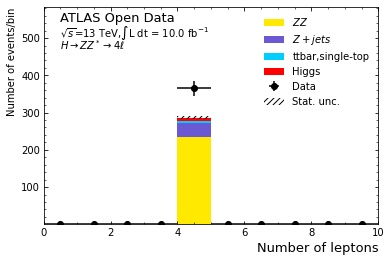

In [37]:
plot_number_leptons(data)

For the number of jets:

In [38]:
def plot_number_jets(data):

    xmin = 0 
    xmax = 5  
    step_size = 1

    bin_edges = np.arange(start=xmin, 
                     stop=xmax+step_size,
                     step=step_size ) 
    bin_centres = np.arange(start=xmin+step_size/2, 
                            stop=xmax+step_size/2,
                            step=step_size )

    data_x,_ = np.histogram(data['data']['number_jets'], 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data
    data_mass_errors = step_size/2

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: 
        if s not in ['data']: 
            mc_x.append( data[s]['number_jets']) 
            mc_weights.append( data[s].totalWeight ) 
            mc_colors.append( samples[s]['color'] ) 
            mc_labels.append( s ) 


    # *************
    # Main plot 
    # *************

    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_x, yerr=data_x_errors,
                       fmt='ko', 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
 
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres,
                  2*mc_x_err, 
                  alpha=0.5,
                  bottom=mc_x_tot-mc_x_err,
                  color='none', hatch="////", width=step_size, label='Stat. unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both',
                          direction='in', 
                          top=True, 
                          right=True ) 
    
    # x-axis label
    main_axes.set_xlabel(r'Jets multiplicity',
                        fontsize=13, x=1, horizontalalignment='right' ) 
    
    main_axes.set_ylabel('Number of events/bin',
                         y=1, horizontalalignment='right')

    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6)
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False)

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, 
             0.93, 
             'ATLAS Open Data', 
             transform=main_axes.transAxes, 
             fontsize=13 ) 
    
  
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) 
    plt.text(0.05, 
             0.865, 
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', 
             transform=main_axes.transAxes ) 
    
    # Add a label for the analysis carried out
    plt.text(0.05, 
             0.805, 
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', 
             transform=main_axes.transAxes )

    # draw the legend
    main_axes.legend( frameon=False ) 

    plt.savefig("number_jets.png",bbox_inches='tight')

    return

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


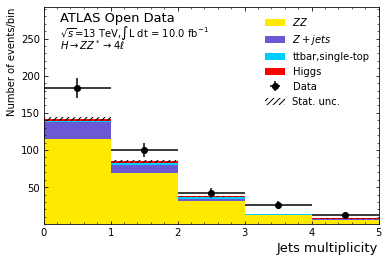

In [39]:
plot_number_jets(data)

The charge of selected events:

In [40]:
def plot_charge(data):

    xmin = -3 
    xmax = 5
    step_size = 1

    bin_edges = np.arange(start=xmin, 
                     stop=xmax+step_size, 
                     step=step_size ) 
    bin_centres = np.arange(start=xmin+step_size/2, 
                            stop=xmax+step_size/2, 
                            step=step_size )

    data_x,_ = np.histogram(data['data']['lepton_charge'], 
                            bins=bin_edges ) 
    data_x_errors = np.sqrt( data_x ) 
    data_mass_errors = step_size/2

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: 
        if s not in ['data']: 
            mc_x.append( data[s]['lepton_charge']) 
            mc_weights.append( data[s].totalWeight )
            mc_colors.append( samples[s]['color'] ) 
            mc_labels.append( s ) 


    # *************
    # Main plot 
    # *************

    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_x, yerr=data_x_errors,
                       fmt='ko', 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
 
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, 
                  2*mc_x_err, 
                  alpha=0.5, 
                  bottom=mc_x_tot-mc_x_err,
                  color='none', hatch="////", width=step_size, label='Stat. unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', 
                          direction='in',
                          top=True, 
                          right=True ) 
    
    # x-axis label
    main_axes.set_xlabel(r'Lepton charge',
                        fontsize=13, x=1, horizontalalignment='right' ) 
    
    main_axes.set_ylabel('Number of events/bin',
                         y=1, horizontalalignment='right')

    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6)
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False)

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05,
             0.93, 
             'ATLAS Open Data', 
             transform=main_axes.transAxes, 
             fontsize=13 ) 
    
  
    # Add energy and luminosity
    lumi_used = str(lumi*fraction)
    plt.text(0.05, 
             0.865, 
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', 
             transform=main_axes.transAxes ) 
    
    # Add a label for the analysis carried out
    plt.text(0.05, 
             0.805, 
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', 
             transform=main_axes.transAxes ) 

    # draw the legend
    main_axes.legend( frameon=False ) 
    plt.savefig("lepton_charge.png",bbox_inches='tight')

    return

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


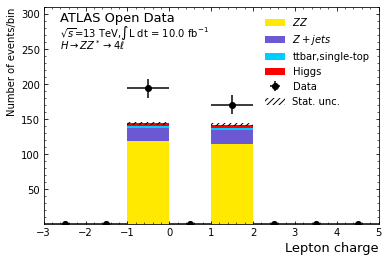

In [41]:
plot_charge(data)

The lepton type, i.e., the lepton flavour (11=electron, 13=muon).

In [42]:
def plot_type(data):

    xmin = 0 
    xmax = 25
    step_size = 1

    bin_edges = np.arange(start=xmin, 
                     stop=xmax+step_size, 
                     step=step_size ) 
    bin_centres = np.arange(start=xmin+step_size/2, 
                            stop=xmax+step_size/2, 
                            step=step_size )

    data_x,_ = np.histogram(data['data']['lepton_type'], 
                            bins=bin_edges ) 
    data_x_errors = np.sqrt( data_x ) 
    data_mass_errors = step_size/2

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: 
        if s not in ['data']: 
            mc_x.append( data[s]['lepton_type']) 
            mc_weights.append( data[s].totalWeight ) 
            mc_colors.append( samples[s]['color'] ) 
            mc_labels.append( s ) 

    # *************
    # Main plot 
    # *************

    main_axes = plt.gca() 
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_x, yerr=data_x_errors,
                       fmt='ko', 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] 
 
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, 
                  2*mc_x_err, 
                  alpha=0.5, 
                  bottom=mc_x_tot-mc_x_err,
                  color='none', hatch="////", width=step_size, label='Stat. unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', 
                          direction='in', 
                          top=True,
                          right=True ) 
    
    # x-axis label
    main_axes.set_xlabel(r'Lepton type',
                        fontsize=13, x=1, horizontalalignment='right' ) 
    
    main_axes.set_ylabel('Number of events/bin',
                         y=1, horizontalalignment='right')

    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6)
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False)

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, 
             0.93, 
             'ATLAS Open Data', 
             transform=main_axes.transAxes, 
             fontsize=13 ) 
    
  
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) 
    plt.text(0.05, 
             0.865, 
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) 
    
    # Add a label for the analysis carried out
    plt.text(0.05, 
             0.805, 
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', 
             transform=main_axes.transAxes ) 

    # draw the legend
    main_axes.legend( frameon=False ) 

    plt.savefig("lepton_type.png",bbox_inches='tight')

    return

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


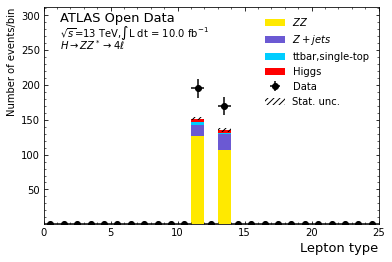

In [43]:
plot_type(data)

The reconstructed invariant mass for the two leading leptons:

In [44]:
def plot_ml1l2(data):

    xmin = 50 #GeV
    xmax = 130  #GeV
    step_size = 5 #Gev/bin

    bin_edges = np.arange(start=xmin, 
                     stop=xmax+step_size, 
                     step=step_size ) 
    bin_centres = np.arange(start=xmin+step_size/2, 
                            stop=xmax+step_size/2, 
                            step=step_size ) 

    data_x,_ = np.histogram(data['data']['ml1l2'], 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data
    data_mass_errors = step_size/2

    signal_x = data[r'Higgs']['ml1l2'] # histogram the signal
    signal_weights = data[r'Higgs'].totalWeight # get the weights of the signal events
    signal_color = samples[r'Higgs']['color'] # get the colour for the signal bar


    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples:
        if s not in ['data', r'Higgs']: 
            mc_x.append( data[s]['ml1l2'] ) 
            mc_weights.append( data[s].totalWeight ) 
            mc_colors.append( samples[s]['color'] )
            mc_labels.append( s ) 


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_x, yerr=data_x_errors,
                       fmt='ko', 
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] 
 
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

    #Calculate the Data/Pred. ratio, taking the closest value of the data to the MC value

    data_pred=(data_x-data_x_errors)/mc_x_tot  
    data_pred_errors=np.sqrt(data_pred) #stat. unc.

    # plot the signal bar
    main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
                   weights=signal_weights, color=signal_color,
                   label=r'Higgs')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, 
                  2*mc_x_err,
                  alpha=0.5, 
                  bottom=mc_x_tot-mc_x_err,
                  color='none', hatch="////", width=step_size, label='Stat. unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', 
                          direction='in', 
                          top=True, 
                          right=True ) 
    
    # x-axis label
    #main_axes.set_xlabel(r'$\mathrm{m_{T}(4l)}$ [GeV]',
    #                    fontsize=13, x=1, horizontalalignment='right' ) 
    
    main_axes.set_ylabel('Number of events/bin',
                         y=1, horizontalalignment='right')

    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.5)
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False)

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05,
             0.93, 
             'ATLAS Open Data', 
             transform=main_axes.transAxes, 
             fontsize=13 )

  
    # Add energy and luminosity
    lumi_used = str(lumi*fraction)
    plt.text(0.05, 
             0.865, 
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', 
             transform=main_axes.transAxes ) 
    
    # Add a label for the analysis carried out
    plt.text(0.05, 
             0.805, 
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', 
             transform=main_axes.transAxes ) 

    # draw the legend
    main_axes.legend( frameon=False )

    # *************
    # Data-Bkg plot 
    # *************
    plt.axes([0.125,-0.1,0.775,0.225]) # left, bottom, width, height
    sub_axes = plt.gca() # get the current axes

    # set the y axis to be symmetric about Data-Background=0
    sub_axes.yaxis.set_major_locator( MaxNLocator(nbins='auto', 
                                                  symmetric=True) )
    
    sub_axes.set_ylim(bottom=0, top=np.amax(data_pred)*1.5)

    # plot Data-Background
    sub_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_pred, yerr=data_pred_errors,
                      fmt='ko' ) 

    sub_axes.axhline(1.0,ls='--',c='b')               

    # set the x-axis limits on the sub axes
    sub_axes.set_xlim( left=xmin, right=xmax )

    # separation of x-axis minor ticks
    sub_axes.xaxis.set_minor_locator( AutoMinorLocator() )
    
    # x-axis label
    sub_axes.set_xlabel(r'$\mathrm{m_{2\ell_{1}\ell_{2}}}$ [GeV]',
                        x=1, horizontalalignment='right', 
                        fontsize=13 )
    
    # set the tick parameters for the sub axes
    sub_axes.tick_params(which='both', 
                         direction='in', 
                         top=True, 
                         right=True ) 

    # separation of y-axis minor ticks
    sub_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    sub_axes.set_yticks([-1.0,0,1.0,2.0])

    # y-axis label on the sub axes
    sub_axes.set_ylabel( 'Data/Pred' )

    # Generic features for both plots
    main_axes.yaxis.set_label_coords( -0.09, 1 ) 
    sub_axes.yaxis.set_label_coords( -0.09, 0.5 ) 

    plt.savefig("m_l1l2.png",bbox_inches='tight')

    return

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


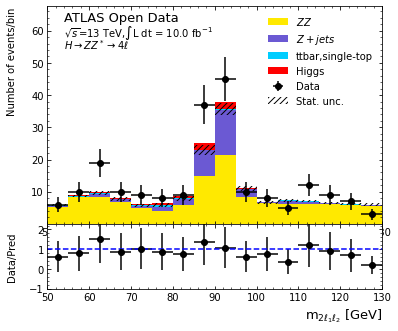

In [45]:
plot_ml1l2(data)

The reconstructed invariant mass for the 2-leptons with the lowest momentum and energy:

In [46]:
def plot_ml3l4(data):

    xmin = 20 #GeV
    xmax = 140  #GeV
    step_size = 5 #Gev/bin

    bin_edges = np.arange(start=xmin,
                     stop=xmax+step_size, 
                     step=step_size ) 
    bin_centres = np.arange(start=xmin+step_size/2, 
                            stop=xmax+step_size/2, 
                            step=step_size )

    data_x,_ = np.histogram(data['data']['ml3l4'], 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data
    data_mass_errors = step_size/2

    signal_x = data[r'Higgs']['ml3l4'] # histogram the signal
    signal_weights = data[r'Higgs'].totalWeight # get the weights of the signal events
    signal_color = samples[r'Higgs']['color'] # get the colour for the signal bar


    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data', r'Higgs']: # if not data nor signal
            mc_x.append( data[s]['ml3l4'] ) 
            mc_weights.append( data[s].totalWeight ) 
            mc_colors.append( samples[s]['color'] )
            mc_labels.append( s ) 


    # *************
    # Main plot 
    # *************

    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_x, yerr=data_x_errors,
                       fmt='ko',  
                       label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
 
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])

    #Calculate the Data/Pred. ratio, taking the closest value of the data to the MC value

    data_pred=(data_x-data_x_errors)/mc_x_tot 
    data_pred_errors=np.sqrt(data_pred) #stat. unc.

    # plot the signal bar
    main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
                   weights=signal_weights, color=signal_color,
                   label=r'Higgs')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, 
                  2*mc_x_err, 
                  alpha=0.5, 
                  bottom=mc_x_tot-mc_x_err,
                  color='none', hatch="////", width=step_size, label='Stat. unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', 
                          direction='in', 
                          top=True, 
                          right=True ) 
    
    # x-axis label
    #main_axes.set_xlabel(r'$\mathrm{m_{T}(4l)}$ [GeV]',
    #                    fontsize=13, x=1, horizontalalignment='right' ) 
    
    main_axes.set_ylabel('Number of events/bin',
                         y=1, horizontalalignment='right')

    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.5)
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    
    # avoid displaying y=0 on the main axes
    main_axes.yaxis.get_major_ticks()[0].set_visible(False)

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, 
             0.93, 
             'ATLAS Open Data', 
             transform=main_axes.transAxes, 
             fontsize=13 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.865, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', 
             transform=main_axes.transAxes )
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.805, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', 
             transform=main_axes.transAxes ) 

    # draw the legend
    main_axes.legend( frameon=False ) 

    # *************
    # Data-Bkg plot 
    # *************
    plt.axes([0.125,-0.1,0.775,0.225]) 
    sub_axes = plt.gca() 

    # set the y axis to be symmetric about Data-Background=0
    sub_axes.yaxis.set_major_locator( MaxNLocator(nbins='auto', 
                                                  symmetric=True) )
    
    sub_axes.set_ylim(bottom=0, top=np.amax(data_pred)*1.5)

    # plot Data-Background
    sub_axes.errorbar(x=bin_centres, xerr=data_mass_errors, y=data_pred, yerr=data_pred_errors,
                      fmt='ko' ) 

    sub_axes.axhline(1.0,ls='--',c='b')                  

    # set the x-axis limits on the sub axes
    sub_axes.set_xlim( left=xmin, right=xmax )

    # separation of x-axis minor ticks
    sub_axes.xaxis.set_minor_locator( AutoMinorLocator() )
   
    
    # x-axis label
    sub_axes.set_xlabel(r'$\mathrm{m_{2\ell_{3}\ell_{4}}}$ [GeV]',
                        x=1, horizontalalignment='right', 
                        fontsize=13 )
    
    # set the tick parameters for the sub axes
    sub_axes.tick_params(which='both', 
                         direction='in', 
                         top=True, 
                         right=True ) 

    # separation of y-axis minor ticks
    sub_axes.yaxis.set_minor_locator( AutoMinorLocator() )
    sub_axes.set_yticks([-1.0,0,1.0,2.0])

    # y-axis label on the sub axes
    sub_axes.set_ylabel( 'Data/Pred' )

    # Generic features for both plots
    main_axes.yaxis.set_label_coords( -0.09, 1 ) 
    sub_axes.yaxis.set_label_coords( -0.09, 0.5 )

    plt.savefig("m_l3l4.png",bbox_inches='tight')

    return

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


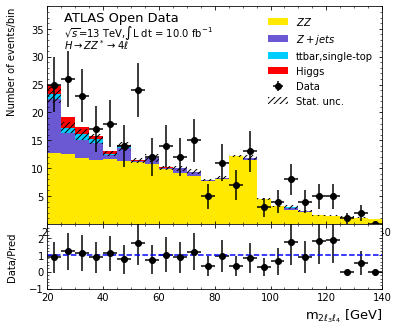

In [47]:
plot_ml3l4(data)

Calculation of some numbers:



*   Number of events selected from the data: 

            Data = 365 events


*   Number of expected signal events:

            S = 385706



*   Number of MC Background events:

           B = 566742


In [48]:
D=365
S=320286
B=457910

#Data/MC ratio:
D_B=D/B

#Signal efficiency

e=S/B

#The purity of the signal:
P=S/(S+B)

#Approximate significance of our signal (for measurements):
a1=S/math.sqrt(S+B)

#Approximate significance of our signal (for searches):
a2=S/math.sqrt(B)

print("Data/MC ratio:",D_B)
print("Signal efficiency:",e)
print("Purity of the signal:",P)
print("Approx. significance of our signal for measurements:",a1)
print("Approx. significance of our signal for searches:",a2)

Data/MC ratio: 0.0007970998667860496
Signal efficiency: 0.6994518573518814
Purity of the signal: 0.4115749759700641
Approx. significance of our signal for measurements: 363.07258606723246
Approx. significance of our signal for searches: 473.3124101307768
